In [1]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import preprocessing
import os
print("os.listdir")
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import ensemble
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from decimal import *

os.listdir


# Importing Database

In [2]:
%%time
event_type=pd.read_csv("event_type.csv",error_bad_lines=False,warn_bad_lines=False)
train = pd.read_csv("train.csv")
severity_type = pd.read_csv("severity_type.csv")
log_feature = pd.read_csv("log_feature.csv")
test = pd.read_csv("test.csv")
resource_type = pd.read_csv("resource_type.csv",error_bad_lines=False,warn_bad_lines=False)
sample_submission = pd.read_csv("sample_submission.csv")

Wall time: 420 ms


In [3]:
print("test",test.shape)
print("train",train.shape)

test (11171, 2)
train (7381, 3)


In [4]:
test.nunique()

id          11171
location     1039
dtype: int64

### Input Datasets Heads

In [5]:
print('test',test.head())
print('train',train.head())
print('sample_submission',sample_submission.head())
print('event_type',event_type.shape,event_type.head())
print('severity_type',severity_type.shape,severity_type.head())
print('log_feature',log_feature.shape,log_feature.head())
print('resource_type',resource_type.shape,resource_type.head())

test       id  location
0  11066       481
1  18000       962
2  16964       491
3   4795       532
4   3392       600
train       id      location  fault_severity
0  14121  location 118               1
1   9320   location 91               0
2  14394  location 152               1
3   8218  location 931               1
4  14804  location 120               0
sample_submission       id  predict_0  predict_1  predict_2
0  11066          0          1          0
1  18000          0          1          0
2  16964          0          1          0
3   4795          0          1          0
4   3392          0          1          0
event_type (31171, 2)      id     event_type
0  6597  event_type 11
1  8011  event_type 15
2  2597  event_type 15
3  5022  event_type 15
4  5022  event_type 11
severity_type (18552, 2)      id    severity_type
0  6597  severity_type 2
1  8011  severity_type 2
2  2597  severity_type 2
3  5022  severity_type 1
4  6852  severity_type 1
log_feature (58671, 3)      id  log_

In [6]:
severity_type.nunique()

id               18552
severity_type        5
dtype: int64

### Visualisation of Severity

In [7]:
train.fault_severity.value_counts()

0    4784
1    1871
2     726
Name: fault_severity, dtype: int64

In [8]:
val=list(train['fault_severity'].value_counts())
for i in range(len(val)):
    print(train['fault_severity'].value_counts().index[i],round(val[i]/sum(val)*100),'%')

0 65 %
1 25 %
2 10 %


##### Data Conversion

In [9]:
event_type['id']=pd.to_numeric(event_type['id'],errors='coerce')

In [10]:
event_type.dtypes

id            float64
event_type     object
dtype: object

# Training Preprocessing

### Merging

In [11]:
def merge_fn(df1,df2,col_name,how_param):
    merged_df=df1.merge(df2,how=how_param,on=col_name)
    return merged_df

In [12]:
train_merge1=merge_fn(train,event_type.drop_duplicates(subset=['id']),'id','left')
train_merge2=merge_fn(train_merge1,severity_type.drop_duplicates(subset=['id']),'id','left')
train_merge3=merge_fn(train_merge2,log_feature.drop_duplicates(subset=['id']),'id','left')
train_merge4=merge_fn(train_merge3,resource_type.drop_duplicates(subset=['id']),'id','left')

In [13]:
train_merge4.dtypes

id                 int64
location          object
fault_severity     int64
event_type        object
severity_type     object
log_feature       object
volume             int64
resource_type     object
dtype: object

In [14]:
train_merge4.head()

,id,location,fault_severity,event_type,severity_type,log_feature,volume,resource_type
0,14121,location 118,1,event_type 34,severity_type 2,feature 312,19,resource_type 2
1,9320,location 91,0,event_type 34,severity_type 2,feature 315,200,resource_type 2
2,14394,location 152,1,event_type 35,severity_type 2,feature 221,1,resource_type 2
3,8218,location 931,1,event_type 15,severity_type 1,feature 80,9,resource_type 8
4,14804,location 120,0,event_type 34,severity_type 1,feature 134,1,resource_type 2


### Merged Training Data

In [15]:
train_merge4.head()

,id,location,fault_severity,event_type,severity_type,log_feature,volume,resource_type
0,14121,location 118,1,event_type 34,severity_type 2,feature 312,19,resource_type 2
1,9320,location 91,0,event_type 34,severity_type 2,feature 315,200,resource_type 2
2,14394,location 152,1,event_type 35,severity_type 2,feature 221,1,resource_type 2
3,8218,location 931,1,event_type 15,severity_type 1,feature 80,9,resource_type 8
4,14804,location 120,0,event_type 34,severity_type 1,feature 134,1,resource_type 2


In [16]:
train_merge4.dtypes

id                 int64
location          object
fault_severity     int64
event_type        object
severity_type     object
log_feature       object
volume             int64
resource_type     object
dtype: object

### Checking for missing values

In [17]:
train_merge4.isnull().sum()

id                0
location          0
fault_severity    0
event_type        0
severity_type     0
log_feature       0
volume            0
resource_type     0
dtype: int64

### Finding categorical columns

In [18]:
cat_col=list(set(train_merge4.columns)-set(train_merge4._get_numeric_data().columns))

In [19]:
cat_col

['event_type', 'severity_type', 'resource_type', 'log_feature', 'location']

### Categorical conversion

In [20]:
def categorical_conversion(df,cat_col):
    for i in range(len(cat_col)):
        df[cat_col[i]]=df[cat_col[i]].astype('category')
    return df

In [21]:
train_merge4=categorical_conversion(train_merge4,cat_col)

In [22]:
train_merge4.dtypes

id                   int64
location          category
fault_severity       int64
event_type        category
severity_type     category
log_feature       category
volume               int64
resource_type     category
dtype: object

### Label encoding

In [23]:
def label_encoding_conversion(df,cat_col):
    le=preprocessing.LabelEncoder()
    for i in range(len(cat_col)):
        df[cat_col[i]]=le.fit_transform(df[cat_col[i]])
    return df

In [24]:
train_merge4.columns

Index(['id', 'location', 'fault_severity', 'event_type', 'severity_type',
       'log_feature', 'volume', 'resource_type'],
      dtype='object')

In [25]:
train_merge4=label_encoding_conversion(train_merge4,cat_col)

In [26]:
train_merge4.columns

Index(['id', 'location', 'fault_severity', 'event_type', 'severity_type',
       'log_feature', 'volume', 'resource_type'],
      dtype='object')

In [27]:
train_merge4.head()

,id,location,fault_severity,event_type,severity_type,log_feature,volume,resource_type
0,14121,131,1,22,1,143,19,2
1,9320,850,0,22,1,146,200,2
2,14394,163,1,23,1,88,1,2
3,8218,870,1,5,0,211,9,8
4,14804,134,0,22,0,21,1,2


### Setting the Target

In [28]:
train_merge4.drop(['id'],axis=1,inplace=True)

In [29]:
train_merge4['fault_severity'].unique()

array([1, 0, 2], dtype=int64)

In [30]:
target=train_merge4[['fault_severity']]

In [31]:
train_merge4.drop(['fault_severity'],axis=1,inplace=True)

In [32]:
train_merge4.head()

,location,event_type,severity_type,log_feature,volume,resource_type
0,131,22,1,143,19,2
1,850,22,1,146,200,2
2,163,23,1,88,1,2
3,870,5,0,211,9,8
4,134,22,0,21,1,2


In [33]:
train_merge4.dtypes

location         int32
event_type       int32
severity_type    int32
log_feature      int32
volume           int64
resource_type    int32
dtype: object

In [34]:
test.head()

,id,location
0,11066,481
1,18000,962
2,16964,491
3,4795,532
4,3392,600


### Test Data Preparation

In [35]:
test.head()

,id,location
0,11066,481
1,18000,962
2,16964,491
3,4795,532
4,3392,600


In [36]:
test.shape

(11171, 2)

## Test Data Merging

In [37]:
test_merge1=merge_fn(test,event_type.drop_duplicates(subset=['id']),'id','left')
test_merge2=merge_fn(test_merge1,severity_type.drop_duplicates(subset=['id']),'id','left')
test_merge3=merge_fn(test_merge2,log_feature.drop_duplicates(subset=['id']),'id','left')
test_merge4=merge_fn(test_merge3,resource_type.drop_duplicates(subset=['id']),'id','left')

In [38]:
test_merge4.shape

(11171, 7)

In [39]:
test_merge4.head()

,id,location,event_type,severity_type,log_feature,volume,resource_type
0,11066,481,event_type 35,severity_type 2,feature 230,24,resource_type 2
1,18000,962,event_type 11,severity_type 1,feature 203,9,resource_type 8
2,16964,491,event_type 35,severity_type 2,feature 235,10,resource_type 2
3,4795,532,event_type 27,severity_type 5,feature 240,1,resource_type 3
4,3392,600,event_type 15,severity_type 2,feature 82,6,resource_type 8


In [40]:
severity_type.head()

,id,severity_type
0,6597,severity_type 2
1,8011,severity_type 2
2,2597,severity_type 2
3,5022,severity_type 1
4,6852,severity_type 1


In [41]:
test_merge4.head(2)

,id,location,event_type,severity_type,log_feature,volume,resource_type
0,11066,481,event_type 35,severity_type 2,feature 230,24,resource_type 2
1,18000,962,event_type 11,severity_type 1,feature 203,9,resource_type 8


### Categorical columns

In [42]:
cat_col

['event_type', 'severity_type', 'resource_type', 'log_feature', 'location']

### Categorical conversion

In [43]:
test_merge4=categorical_conversion(test_merge4,cat_col)

In [44]:
test_merge4.dtypes

id                  int64
location         category
event_type       category
severity_type    category
log_feature      category
volume              int64
resource_type    category
dtype: object

### Label encoding

In [45]:
test_merge4=label_encoding_conversion(test_merge4,cat_col)

In [46]:
test_merge4.dtypes

id               int64
location         int64
event_type       int32
severity_type    int32
log_feature      int32
volume           int64
resource_type    int32
dtype: object

### Removing unique columns

In [47]:
test_merge4.drop(['id'],axis=1,inplace=True)

In [48]:
train_merge4.columns

Index(['location', 'event_type', 'severity_type', 'log_feature', 'volume',
       'resource_type'],
      dtype='object')

In [49]:
test_merge4.columns

Index(['location', 'event_type', 'severity_type', 'log_feature', 'volume',
       'resource_type'],
      dtype='object')

In [50]:
test_merge4.head()

,location,event_type,severity_type,log_feature,volume,resource_type
0,441,25,1,106,24,2
1,881,2,0,84,9,8
2,450,25,1,111,10,2
3,484,17,4,115,1,3
4,540,6,1,235,6,8


### Logistic Regression

In [51]:
train_merge4.columns

Index(['location', 'event_type', 'severity_type', 'log_feature', 'volume',
       'resource_type'],
      dtype='object')

In [52]:
lr=LogisticRegression()
lr.fit(train_merge4,target)
lr_pred=lr.predict(test_merge4)
accuracy_score(pd.DataFrame(lr.predict(train_merge4)),target)

C:\Users\Timothius Hermawan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Timothius Hermawan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Timothius Hermawan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.6501829020457932

### Random Forest Classifier

In [97]:
rf=RandomForestClassifier(9)
rf.fit(train_merge4,target)
rf_pred=rf.predict(test_merge4)
accuracy_score(pd.DataFrame(rf.predict(train_merge4)),target)

C:\Users\Timothius Hermawan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.9501422571467281

### Decision Tree Classifier

In [98]:
dt=tree.DecisionTreeClassifier()
dt.fit(train_merge4,target)
dt.predict(test_merge4)
accuracy_score(pd.DataFrame(dt.predict(train_merge4)),target)

0.9697872916948923

### SVC

In [99]:
svc_ml=svm.SVC()
svc_ml.fit(train_merge4,target)
svc_ml.predict(test_merge4)
accuracy_score(pd.DataFrame(svc_ml.predict(train_merge4)),target)

C:\Users\Timothius Hermawan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Timothius Hermawan\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.8968974393713589

### K Neighbors Classifier

In [56]:
knn=KNeighborsClassifier()
knn.fit(train_merge4,target)
knn.predict(test_merge4)
accuracy_score(pd.DataFrame(knn.predict(train_merge4)),target)

C:\Users\Timothius Hermawan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


0.7601950955155128

## Model comparison consolidate function

In [104]:
dic_data={}
list1=[]
max_clf_output=[]
tuple_l=()
def data_modeling(X,target,model):
    for i in range(len(model)):
        ml=model[i]
        ml.fit(X,target)
        pred=ml.predict(X)
        acc_score=accuracy_score(pd.DataFrame(ml.predict(X)),target)
        tuple_l=(ml.__class__.__name__,acc_score)
        dic_data[ml.__class__.__name__]=[acc_score,ml]
        list1.append(tuple_l)
        print(dic_data)
    for name,val in dic_data.items():
        if val==max(dic_data.values()):
            max_lis=[name,val]
            print('Maximum classifier',name,val)

    return list1,max_lis

list1,max_lis=data_modeling(train_merge4,target,[KNeighborsClassifier(),
svm.SVC(),RandomForestClassifier(),
tree.DecisionTreeClassifier(),
LogisticRegression()])

C:\Users\Timothius Hermawan\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


{'KNeighborsClassifier': [0.7601950955155128, KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')]}


C:\Users\Timothius Hermawan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Timothius Hermawan\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


{'KNeighborsClassifier': [0.7601950955155128, KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')], 'SVC': [0.8968974393713589, SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)]}
{'KNeighborsClassifier': [0.7601950955155128, KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')], 'SVC': [0.8968974393713589, SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, ver

C:\Users\Timothius Hermawan\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Timothius Hermawan\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
C:\Users\Timothius Hermawan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Timothius Hermawan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Timothius H

{'KNeighborsClassifier': [0.7601950955155128, KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')], 'SVC': [0.8968974393713589, SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)], 'RandomForestClassifier': [0.952716434087522, RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
         

In [105]:
model=max_lis[1][1]

## Model score Visualization

In [106]:
modelscore_df=pd.DataFrame(list1,columns=['Classifier',"Accuracy score"])

In [107]:
modelscore_df

,Classifier,Accuracy score
0,KNeighborsClassifier,0.760195
1,SVC,0.896897
2,RandomForestClassifier,0.952716
3,DecisionTreeClassifier,0.969787
4,LogisticRegression,0.650183


In [108]:
modelscore_df['classifier code']=np.arange(5)

In [109]:
modelscore_df

,Classifier,Accuracy score,classifier code
0,KNeighborsClassifier,0.760195,0
1,SVC,0.896897,1
2,RandomForestClassifier,0.952716,2
3,DecisionTreeClassifier,0.969787,3
4,LogisticRegression,0.650183,4


In [63]:
modelscore_df.shape[0]

5

### Classifier Selection

In [64]:
clf_sel=modelscore_df.iloc[modelscore_df['Accuracy score'].idxmax()]
clf_name=clf_sel[0]

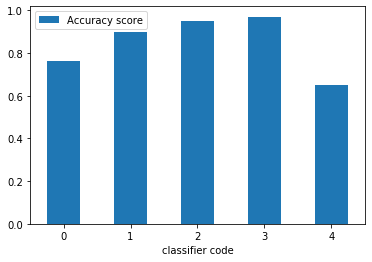

In [65]:
modelscore_df.plot.bar(x='classifier code', y='Accuracy score', rot=0)

# Prediction

In [66]:
predict_test=rf.predict_proba(test_merge4)
pred_df=pd.DataFrame(predict_test,columns=['No_Fault', 'A_Few_Faults', 'Many_Faults'])
submission=pd.concat([test[['id']],pred_df],axis=1)
sub=merge_fn(submission,test.drop_duplicates(subset=['id']),'id','left')


In [67]:
sub

,id,No_Fault,A_Few_Faults,Many_Faults,location
0,11066,1.000000,0.000000,0.000000,481
1,18000,0.222222,0.222222,0.555556,962
2,16964,1.000000,0.000000,0.000000,491
3,4795,0.333333,0.666667,0.000000,532
4,3392,0.555556,0.111111,0.333333,600
5,3795,0.111111,0.666667,0.222222,794
6,2881,0.666667,0.333333,0.000000,375
7,1903,0.222222,0.111111,0.666667,638
8,5245,0.500000,0.500000,0.000000,690
9,6726,1.000000,0.000000,0.000000,893


# Grouping

In [68]:
mean_1 = sub.groupby('location')["No_Fault"].mean().rename("No Fault").reset_index()#*100
submerge1 = sub.merge(mean_1)
mean_2 = sub.groupby('location')["A_Few_Faults"].mean().rename("A Few Faults").reset_index()#*100
submerge2 = submerge1.merge(mean_2)
mean_3 = sub.groupby('location')["Many_Faults"].mean().rename("Many Faults").reset_index()#*100
submerge3 = submerge2.merge(mean_3)
finaldrop = submerge3.drop(columns = ['No_Fault','A_Few_Faults', 'Many_Faults','id'])
fsub = finaldrop.drop_duplicates()
data = fsub.sort_values(by = 'location',ascending = True)
data.head()
#finaldata.to_csv('finaldata.csv',index=False,header=True)

,location,No Fault,A Few Faults,Many Faults
3078,1,0.524033,0.327819,0.148148
7386,2,0.555556,0.348148,0.096296
10905,3,0.833333,0.166667,0.000000
8637,4,0.634921,0.238095,0.126984
10983,6,0.888889,0.111111,0.000000


# Finding Higher Possibilities

In [69]:
highpos = data.groupby("location").idxmax(axis = 1).rename("Severity Type").reset_index()
data2 = data.merge(highpos)
data3 = data2.drop(columns = "level_1")
data3.head()
data3.to_csv('data3.csv',index=False,header=True)

# Adding longitute & latitude

In [70]:
df = pd.read_csv("ltla.csv")
finals = data3.merge(df)
finals.to_csv('finals.csv',index=False,header=True)